# TNE-POT Data preprocessing
This notebook is used to preprocess the data recorded during POT experiments. 

Data, 5 files.xdf per subject :
- 2 EEG baseline recordings, 2 minutes with eyes closed and 2 minutes with eyes open
- 2 EEG motor imagery recordings (MIpre and MIpost), 60 tasks each, 20 with left arm, 20 with right arm, 20 with third limb
- 1 EEG+GSR conditioning phase (in VR) recording, 60 tasks each, 20 with left arm, 20 with right arm, 20 with third limb
- Each file contains multiple streams corresponding to the sensors, MI markers and Unity markers

Preprocessing steps : 
- Extract the streams needed for the analysis
- Use MNE framework to preprocess the data (filter, interpolate bad channels, epoch, reject bad epochs, CAR)
- Extract the 3 frequencies of interest (alpha, beta, gamma) for each epoch
- Use Pandas to calculate the power of the signal and apply baseline normalization to get evoked power for each frequency band 
- Perform a moving average on the evoked power
- Save the data in a new csv file
- Save infos about the processing of all file in a single `recap.csv` file

How to use this notebook :
- Restart the kernel, clear the output and run all cells
- After the first beep the notebook will ask you to enter the group number (1 to 4), the subject number (1 to 10) and the experiment number (1 to 3)
- After the second beep, the notebook will show an error message, this is normal, it is just to stop the execution of the notebook
- You must then check the graph of the raw data to determine if there are bad channels that needs to be interpolated. If there are bad channels, you must add them to the `bad_channels` list in the next cell.
- Then run the cell below the error message to continue the execution of the notebook
- After a few seconds, a beep will be heard and an error message will appear.
- Check the epochs execusion messages to see if there are too many bad epochs (more than 5/20 for a condition) and if there are, consider adding bad channels and re-running the cells after the first error message. If there are too many bad epochs, you can also consider removing the subject from the analysis.
- Finally run the cell below the second error message to save the data in a csv file and update the `recap.csv` file (if the file already exist, it will ask you if you want to overwrite it, if you do it will also update the `recap.csv` file)
- Repeat the process for all 3 experiments and for each subject of each group

## Update

With this version of the file we also use CSP dcomposition on the epoched data with SVC to report f1-scores and cofusion matrix in the recap file. 

Some code is also provided to plot Topomaps of specific frequency band (alpha, beta and gamma) and condition (left, right and third arm)

Imports
-`%matplotlib widget` is used to enable interactive plots.
-`load_ext autoreload` is used to reload the modules when they are modified without having to restart the kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pyxdf  # load file.xdf
import seaborn as sns
from scipy.signal import convolve2d # moving average
import os
import winsound
import csv
# interactive plots
%matplotlib widget 
# autoreload of preprocessing functions
%load_ext autoreload
%autoreload 2
from Preprocessing_functions import *

Keyboard inputs : 1) subject group, 2) subject number, 3) experiment type

In [2]:
winsound.Beep(440, 1000)
# 1) subject group
gp = int(input('Enter subject group [1,2,3,4]: '))
# 2) subject number
sub = int(input('Enter subject number [1,... 40]: '))
# 3) experiment type
exp = int(input('Enter experiment type [1=MIpre, 2=PO, 3=Mipost]: '))

Create the data paths names

In [3]:
# Montage file
MONTAGE = 'DATA/montage_perfect.csv'

# Experiment groups
DICT_GROUP = {1: 'Group_Realistic_Arm', 2: 'Group_Realistic_Arm_Tactile', 3: 'Group_Unrealistic_Arm', 4: 'Group_Unrealistic_Arm_Tactile'}

# Subject
if sub < 10:
    subject = 'sub-S0' + str(sub)
else:
    subject = 'sub-S' + str(sub)

# Experiment
DICT_EXPERIMENT = {1: 'MIpre', 2: 'PO', 3: 'MIpost'}

# data
data_path_name = 'DATA/' + DICT_GROUP[gp] + '/' + subject + '_' + DICT_EXPERIMENT[exp] + '.xdf'

In [4]:
print('Data path: ' + data_path_name)
streams, header = pyxdf.load_xdf(data_path_name)

Data path: DATA/Group_Realistic_Arm/sub-S02_MIpost.xdf


Stream 3: Calculated effective sampling rate 4369.2772 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 12901.4323 Hz is different from specified rate 500.0000 Hz.


EEG data is being loaded
Stream found :2
Creating RawArray with float64 data, n_channels=66, n_times=1530474
    Range : 0 ... 1530473 =      0.000 ...   765.236 secs
Ready.

  
  Raw data information 
 
  <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc, 1 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 2000.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.6s finished


Using matplotlib as 2D backend.


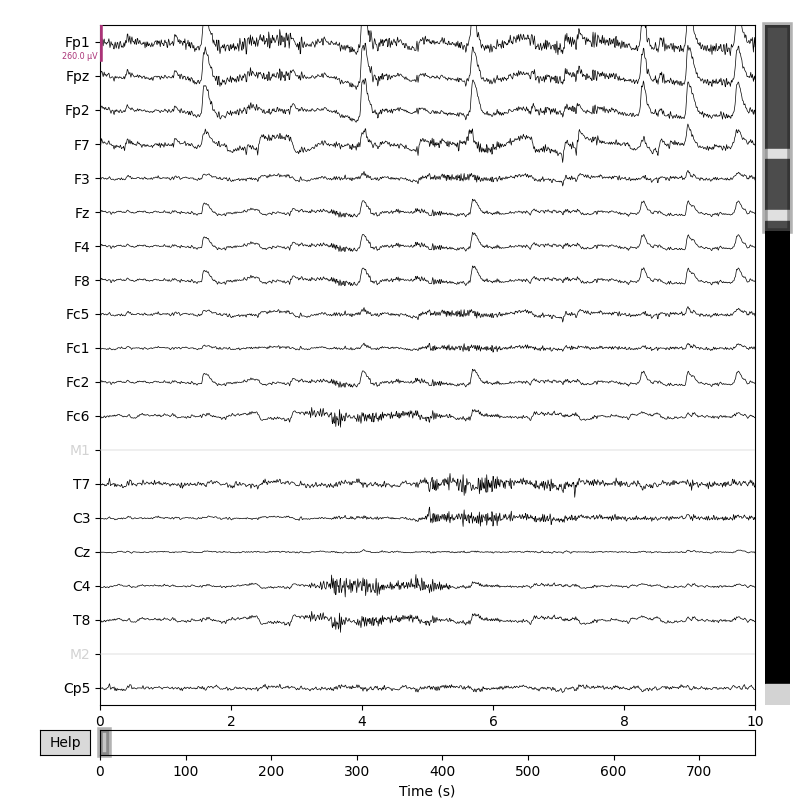

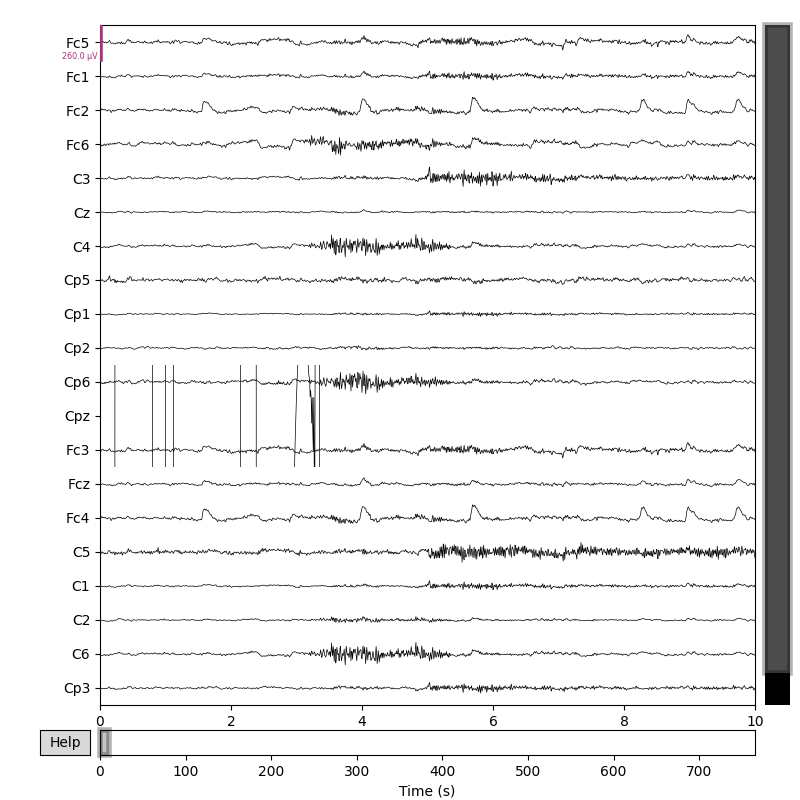

In [5]:
raw_data = get_raw_data(streams, MONTAGE)

Interpolation of bad channels

Interpolating channels:  ['M1', 'M2', 'Trigger', 'GSR', 'Cpz', 'Fc2', 'Fc4'] exclude M1, M2, Trigger
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 3 sensors


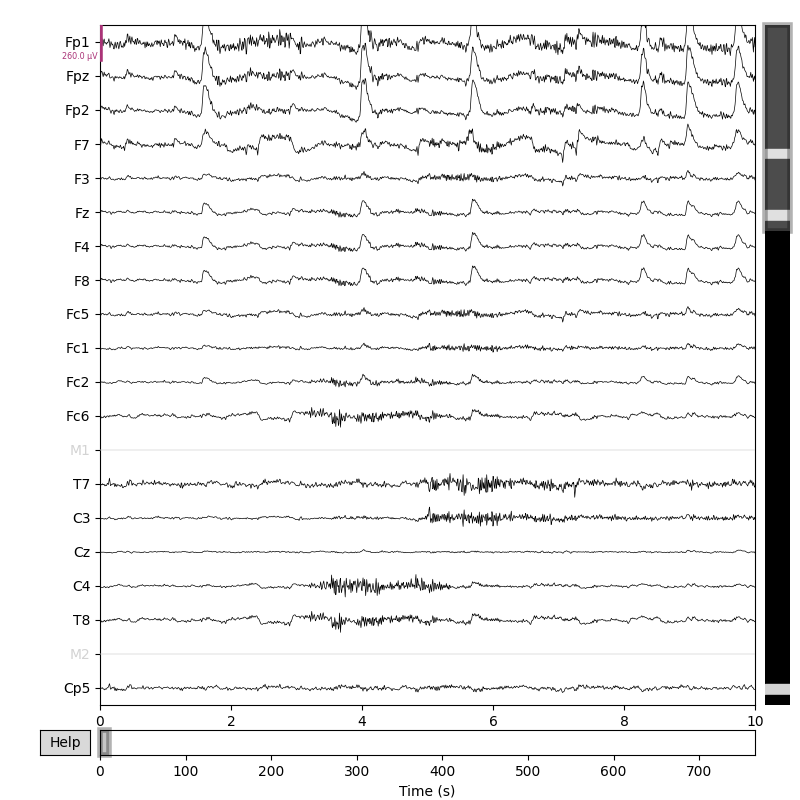

In [6]:
bad_channels = ['Cpz', 'Fc2', 'Fc4']  
montage = get_montage(MONTAGE)
raw_data_interp = interpolate_bad_channels(raw_data, montage, bad_channels = bad_channels)

Epoching

EEG data is being loaded
Stream found :2
MI markers condition are being loaded
Stream found :0
MI markers time are being loaded
Stream found :1
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 12001 original time points ...
    Rejecting  epoch based on EEG : ['Fc6', 'C4', 'Cp6', 'Fc4', 'C6']
    Rejecting  epoch based on EEG : ['Fc5', 'Cp5', 'Fc3', 'C5']
    Rejecting  epoch based on EEG : ['Cp6']
    Rejecting  epoch based on EEG : ['Fc5', 'Fc3']
    Rejecting  epoch based on EEG : ['Fc6', 'C3', 'C4', 'Cp6', 'Fc4', 'C5', 'C6']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C4', 'Cp6', 'C6']
    Rejecting  epoch based on EEG : ['C4', 'Cp6', 'C6']
    Rejecting  epoch based on EEG : ['Fc5', 'Fc1', 'Fc2', 'Fc6', 'C3', 'C4', 'Cp6', 'Fc3', 'Fc4', 'C5', 'C6']
    Rejecting  epoch based on EEG : [

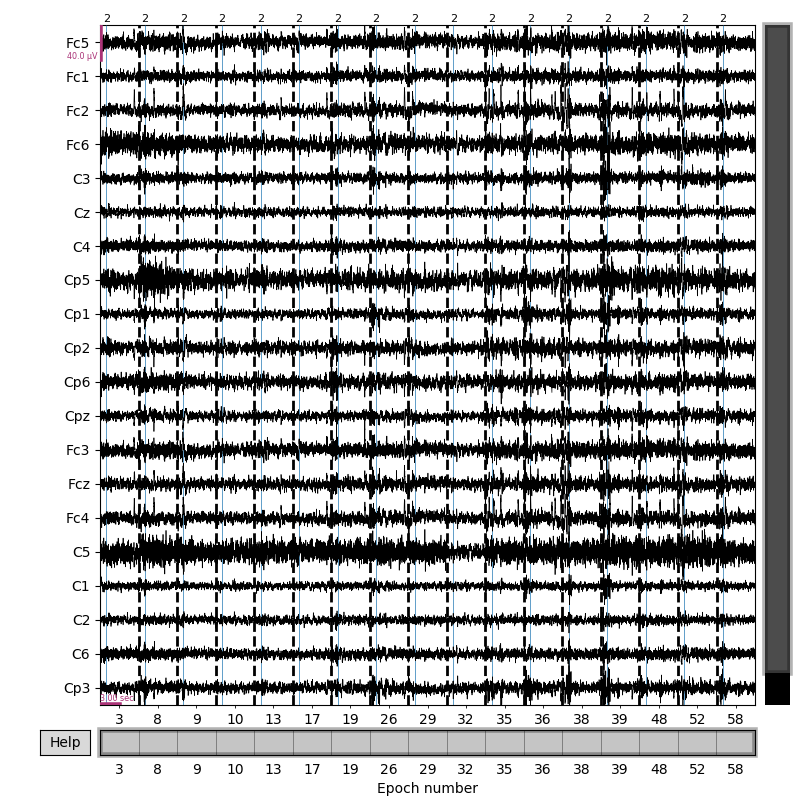

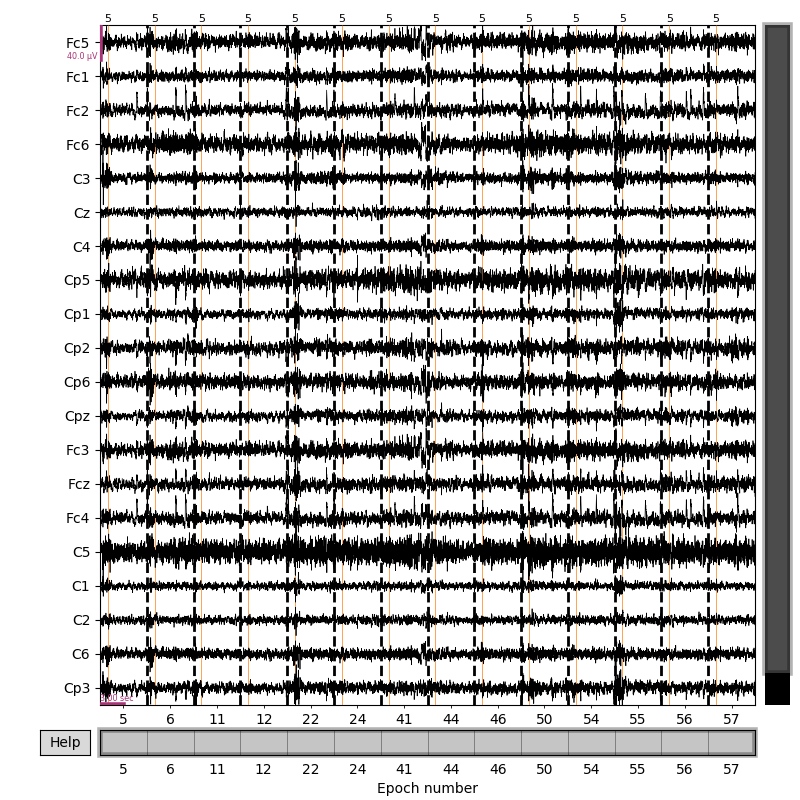

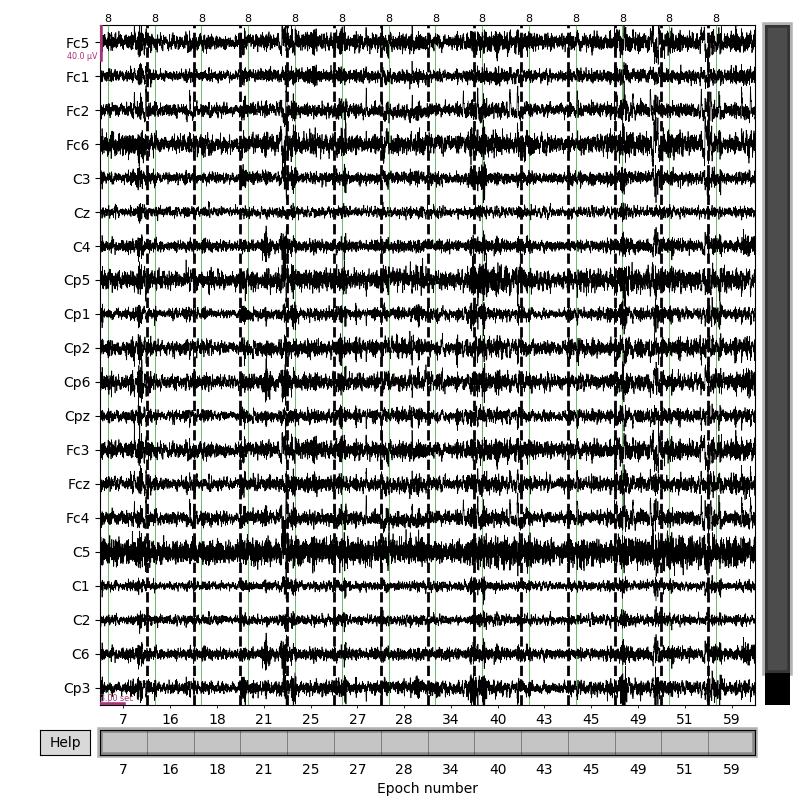

In [7]:
# CAREFULL : if c_channels_only is default (True) we will only keep the C channels and only reject epochs BASED on C channels
epochs_resampled, epochs_original_sp, events, event_ids = get_epochs(streams, raw=raw_data_interp, exp_block=DICT_EXPERIMENT[exp], time_offset=TIME_OFFSET, duration=DURATION)

### CSP model

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Get training and testing data 

epochs = epochs_original_sp.copy() 

X = epochs.get_data()
y = epochs.events[:, -1]
# binarize the labels : Real arms vs Unreal arms
y_bin = np.floor(y/3)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)


## Cross validation with CSP and SVM 

# define the pipeline
pipe = Pipeline([
    ('csp', CSP()),
    ('svc', SVC())
])

# define the parameter grid
param_grid = {
    'csp__n_components': [3, 6],
    'svc__C': [1, 5, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': [0.1, 1, 10]
}

# initialize the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_macro', verbose=1)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# get the best parameters from the grid search
best_params = grid_search.best_params_

# initialize a new pipeline with the best parameters
pipe_best = Pipeline([
    ('csp', CSP(n_components=best_params['csp__n_components'])),
    ('svc', SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'], gamma=best_params['svc__gamma']))
])

# fit the new pipeline to the test data
pipe_best.fit(X_train, y_train)

# make predictions on the test data
y_pred = pipe_best.predict(X_test)

# calculate the f1-score on the test data
f1 = f1_score(y_test, y_pred)

# calculate the confusion matrix on the test data
conf_mat = confusion_matrix(y_test, y_pred)

In [10]:
# print best parameters, f1-score and confusion matrix
print("Grid search best score: ", grid_search.best_score_)
print("Best parameters: ", best_params)
print("F1-score: ", f1)
print("Confusion matrix: ", conf_mat)
TP = conf_mat[0,0] # TN
FP = conf_mat[0,1] # FP
FN = conf_mat[1,0] # FN
TN = conf_mat[1,1] # TP 

### Spectrogram

Calculate the power of the signal for each epoch

In [12]:
df_epochs = epochs_to_dataframe(epochs_resampled)
df_power = calculate_power(df_epochs)
print(df_power.shape)

Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 177 samples (0.885 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 30 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 89 samples (0.445 sec)



[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed:    0.3s finished


(162000, 25)


Calculate the baseline normalization for each epoch

In [13]:
df_baseline = get_baseline(df_power)
df_norm = normalization(df_power, df_baseline)
print(df_norm.shape)

(162000, 25)


Perform a moving average on the evoked power

In [14]:
df_ma = moving_average_for_df(df_norm, WINDOW_SIZE, WINDOW_STEP, RE_SAMPLE_RATE)
print(df_ma.shape)

(7560, 25)


### Topoplots

In [16]:
def get_evoked (df, cdt, band):

    df_topo = df[df['time'] >= 0].copy()
    df_topo['time'] = df_topo['time'].apply(lambda x: x+0.5)
    montage_label = pd.read_csv(MONTAGE)
    channel_label = montage_label['ch_name'].tolist()
    unused_channels = [ch for ch in channel_label if ch not in C_CHANNELS]
    # add a column full of 0 for each unused channel
    for ch in unused_channels:
        df_topo[ch] = 0

    # condition 2 and freq_band alpha
    df_topo = df_topo[(df_topo['condition'] == str(DICT_CONDITIONS[cdt])) & (df_topo['freq_band'] == band)]

    # will need for loop over cdts and freq bands
    # average over epochs
    df_topo = df_topo.groupby(['time']).mean().reset_index()
    df_topo.drop(columns=['epoch'], inplace=True)
    montage = mne.channels.read_custom_montage(MONTAGE)
    info = mne.create_info(ch_names=channel_label, sfreq=10, ch_types='eeg')
    info.set_montage(montage)

    # info['bads'] = unused_channels 
    evoked = mne.EvokedArray(df_topo[channel_label].values.T, info, tmin=0)
    return evoked

C:\Users\thiba\AppData\Local\Temp/ipykernel_1192/81519706.py:21: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(montage)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5]


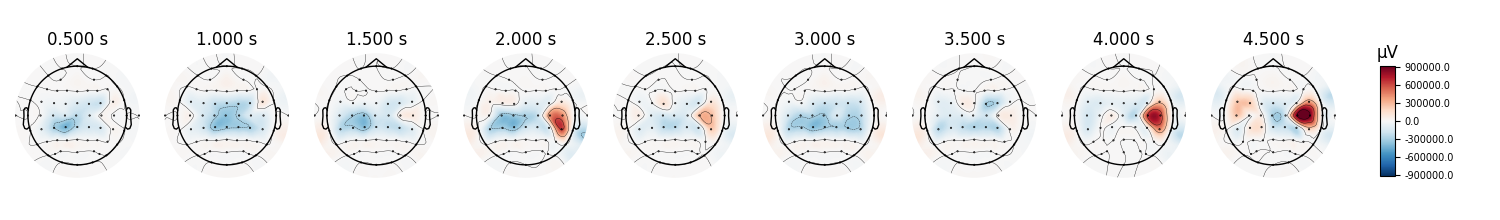

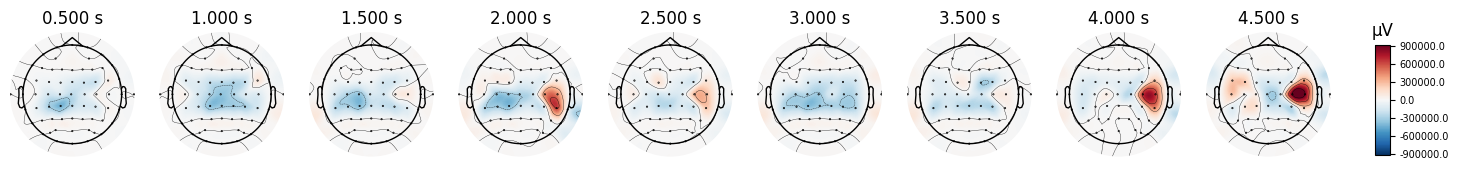

In [32]:
cdt = 'Third'
band = 'beta'
evoked = get_evoked(df_ma[df_ma['time'] >= 0], cdt, band)
print(evoked.times)
times = np.arange(0.5, 5, 0.5)

evoked.plot_topomap(times, sphere='eeglab')

In [23]:
plot_all_conditions_for_specific_channel(df_norm, 'C4')

In [24]:
plot_all_conditions_for_specific_channel(df_ma, 'C4')

Save the csv file and update `recap.csv`

In [26]:
def write_recap_csv(file_path_name):
    # recap values for this run
    recap_dict = {'subject' : subject, 'group' : DICT_GROUP[gp], 'experience' : DICT_EXPERIMENT[exp], 'bandpass[Hz]' : str(BANDPASS_CUTOFF_LOW)+'-'+str(BANDPASS_CUTOFF_HIGH), \
    'nb_channels_used' : len(C_CHANNELS), 'channel_names' : list_to_string(C_CHANNELS), 'nb_channels_interpolated' : len(bad_channels), 'channel_names_interpolated' : list_to_string(bad_channels), \
    'nb_Epochs' : len(df_ma['epoch'].unique()), 'nb_Epochs_Right' : len(df_ma[df_ma['condition'] == '5']['epoch'].unique()), 'nb_Epochs_Left' : len(df_ma[df_ma['condition'] == '2']['epoch'].unique()), 'nb_Epochs_Third' : len(df_ma[df_ma['condition'] == '8']['epoch'].unique()), 'rejection_threshold[uV]' : REJECTION_TH, 'nb_Epochs_rejected' : 60-len(df_ma['epoch'].unique()), \
    'Epoch_tstart[s]' : TIME_OFFSET, 'Epoch_tend[s]' : DURATION, 'baseline_tstart[s]' : TIME_OFFSET, 'baseline_tend[s]' : 0, 'stimulation_tstart[s]' : 0, 'stimulation_tend[s]' : DURATION, \
    'EEG_reference' : 'CAR', 'original_sampling_rate[Hz]' : SAMPLE_RATE, 'resampled_sampling_rate[Hz]' : RE_SAMPLE_RATE, 'alpha_band' : str(A_MIN)+'-'+str(A_MAX), 'beta_band' : str(B_MIN)+'-'+str(B_MAX), 'gamma_band' : str(G_MIN)+'_'+str(G_MAX), \
    'normalization' : 'baseline', 'smoothing' : 'moving_average', 'window_size[s]' : WINDOW_SIZE, 'step_size[s]' : WINDOW_STEP, 'effective_duration[s]' : df_ma['time'].unique().max(), 'file_loc' : file_path_name, \
    'CSP_CV_bscore' : grid_search.best_score_, 'CSP_CV_bparams' : str(grid_search.best_params_), 'CSP_f1_score' : f1, 'CSP_TP' : TP, 'CSP_FP' : FP, 'CSP_TN' : TN, 'CSP_FN' : FN \
    }
    
    # check if DATA/recap.csv exists
    if os.path.exists('DATA/recap.csv'):
        # if it exists, read it
        df_recap = pd.read_csv('DATA/recap.csv', index_col=0)
    else:
        # if it does not exist, create it
        columns = list(recap_dict.keys())
        df_recap = pd.DataFrame(columns=columns)
    # check if subject with same experiment already exists
    if len(df_recap[(df_recap['subject'] == subject) & (df_recap['experience'] == DICT_EXPERIMENT[exp])]) > 0:
        # drop existing row fo subject and experiment
        print('Subject already exists, overwriting')
        df_recap.drop(df_recap.loc[(df_recap['subject'] == subject) & (df_recap['experience'] == DICT_EXPERIMENT[exp])].index, inplace=True)
    df_recap = df_recap.append(recap_dict, ignore_index=True)
    # order the rows by subject and experiment and reset index
    df_recap = df_recap.sort_values(by=['subject', 'experience']).reset_index(drop=True)
    df_recap.to_csv('DATA/recap.csv', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

In [28]:
# dataframe to save in csv
df_ml = df_ma[df_ma['time'] >= 0]

# file path name
folder_path_name = 'DATA/' + DICT_GROUP[gp] + '/' + 'preprocessed_data_folder/'
file_path_name = folder_path_name + subject + '_' + DICT_EXPERIMENT[exp] + '.csv'

# if folder does not exist, create it
if not os.path.exists(folder_path_name):
    os.makedirs(folder_path_name)
    print('folder created')

# if file does not exist, create it
if not os.path.exists(file_path_name):
    print('Saving preprocessed data to file: ', file_path_name)
    df_ml.to_csv(file_path_name, index=False)
    write_recap_csv(file_path_name)
    winsound.Beep(440, 1000)
else:
    winsound.Beep(440, 1000)
    print('File already exists: ', file_path_name)
    print('Do you want to overwrite it?')
    overwrite = input('y/n: ')
    if overwrite == 'y':
        print('Overwriting file: ', file_path_name)
        df_ml.to_csv(file_path_name, index=False)
        write_recap_csv(file_path_name)
    else:
        print('File & recap not overwritten')
    winsound.Beep(440, 1000)

File already exists:  DATA/Group_Realistic_Arm/preprocessed_data_folder/sub-S02_MIpost.csv
Do you want to overwrite it?
File & recap not overwritten


In [29]:
df_recap = pd.read_csv('DATA/recap.csv', index_col=0)
df_recap

subject                        group experience bandpass[Hz]  \
0   sub-S01          Group_Realistic_Arm     MIpost       1.5-40   
1   sub-S01          Group_Realistic_Arm      MIpre       1.5-40   
2   sub-S02          Group_Realistic_Arm     MIpost       1.5-40   
3   sub-S02          Group_Realistic_Arm      MIpre       1.5-40   
4   sub-S02          Group_Realistic_Arm         PO       1.5-40   
5   sub-S03          Group_Realistic_Arm     MIpost       1.5-40   
6   sub-S03          Group_Realistic_Arm      MIpre       1.5-40   
7   sub-S03          Group_Realistic_Arm         PO       1.5-40   
8   sub-S04          Group_Realistic_Arm     MIpost       1.5-40   
9   sub-S04          Group_Realistic_Arm      MIpre       1.5-40   
10  sub-S04          Group_Realistic_Arm         PO       1.5-40   
11  sub-S05          Group_Realistic_Arm     MIpost       1.5-40   
12  sub-S05          Group_Realistic_Arm      MIpre       1.5-40   
13  sub-S05          Group_Realistic_Arm         PO       1.5-40   
14  sub-S07          Group_Realistic_Arm     MIpost       1.5-40   
15  sub-S07          Group_Realistic_Arm      MIpre       1.5-40   
16  sub-S07          Group_Realistic_Arm         PO       1.5-40   
17  sub-S08          Group_Realistic_Arm     MIpost       1.5-40   
18  sub-S08          Group_Realistic_Arm      MIpre       1.5-40   
19  sub-S08          Group_Realistic_Arm         PO       1.5-40   
20  sub-S09          Group_Realistic_Arm     MIpost       1.5-40   
21  sub-S09          Group_Realistic_Arm      MIpre       1.5-40   
22  sub-S09          Group_Realistic_Arm         PO       1.5-40   
23  sub-S10          Group_Realistic_Arm     MIpost       1.5-40   
24  sub-S10          Group_Realistic_Arm      MIpre       1.5-40   
25  sub-S10          Group_Realistic_Arm         PO       1.5-40   
26  sub-S11  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
27  sub-S11  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
28  sub-S11  Group_Realistic_Arm_Tactile         PO       1.5-40   
29  sub-S12  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
30  sub-S12  Group_Realistic_Arm_Tactile         PO       1.5-40   
31  sub-S13  Group_Realistic_Arm_Tactile         PO       1.5-40   
32  sub-S14  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
33  sub-S14  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
34  sub-S14  Group_Realistic_Arm_Tactile         PO       1.5-40   
35  sub-S15  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
36  sub-S15  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
37  sub-S15  Group_Realistic_Arm_Tactile         PO       1.5-40   
38  sub-S16  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
39  sub-S16  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
40  sub-S16  Group_Realistic_Arm_Tactile         PO       1.5-40   
41  sub-S17  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
42  sub-S17  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
43  sub-S17  Group_Realistic_Arm_Tactile         PO       1.5-40   
44  sub-S18  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
45  sub-S18  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
46  sub-S18  Group_Realistic_Arm_Tactile         PO       1.5-40   
47  sub-S19  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
48  sub-S19  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
49  sub-S19  Group_Realistic_Arm_Tactile         PO       1.5-40   
50  sub-S20  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
51  sub-S20  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
52  sub-S20  Group_Realistic_Arm_Tactile         PO       1.5-40   

    nb_channels_used                                      channel_names  \
0                 21  C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...   
1                 21  C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...   
2                 21  C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...   
3                 21  C1,C2,C3,